In [5]:
import os 
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
base_path = "analysis_results"
if os.path.exists(f"{base_path}/connection_peroids.csv"):
    print("Loading existing processed data...")
df_conn_periods = pd.read_csv(f"{base_path}/connection_periods.csv")

In [56]:
df_conn_periods.iloc[0]['TLE_Line2']

'2 47627  53.0546 351.1595 0001386  84.2602 275.8545 15.06411328232453'

In [19]:
df_conn_periods.columns

Index(['Satellite', 'Start_Time', 'End_Time', 'Duration_Seconds',
       'Max_Distance', 'Min_Distance', 'First_Distance', 'Last_Distance',
       'Mean_Distance', 'Std_Distance', 'Mean_Altitude_km', 'Mean_Latency_ms',
       'TLE_Line1', 'TLE_Line2', 'TLE_Timestamp'],
      dtype='object')

In [41]:
# how many unique satellite names are there?
satellite_names = df_conn_periods['Satellite'].unique()
satellite_names = [name for name in satellite_names if name != '']
print(f"Unique satellite names: {satellite_names}")
print(f"Number of unique satellite names: {len(satellite_names)}")
satellite_counts = df_conn_periods['Satellite'].value_counts()
satellite_counts = satellite_counts[satellite_counts.index != '']

# Print the most frequently seen satellite
most_seen_satellite = satellite_counts.idxmax()
most_seen_count = satellite_counts.max()

print(f"Most frequently seen satellite: {most_seen_satellite} ({most_seen_count} times)")
print("\nTop 10 satellites by frequency:")
print(satellite_counts.head(10))

Unique satellite names: ['STARLINK-1972', 'STARLINK-5185', 'STARLINK-5507', 'STARLINK-3629', 'STARLINK-30272', 'STARLINK-32697', 'STARLINK-4208', 'STARLINK-32235', 'STARLINK-1848', 'STARLINK-3651', 'STARLINK-32369', 'STARLINK-6046', 'STARLINK-5200', 'STARLINK-5973', 'STARLINK-31458', 'STARLINK-32304', 'STARLINK-1942', 'STARLINK-5171', 'STARLINK-5174', 'STARLINK-31356', 'STARLINK-32289', 'STARLINK-1608', 'STARLINK-31556', 'STARLINK-31140', 'STARLINK-2568', 'STARLINK-5222', 'STARLINK-3835', 'STARLINK-5482', 'STARLINK-4046', 'STARLINK-30525', 'STARLINK-1200', 'STARLINK-32790', 'STARLINK-5412', 'STARLINK-3451', 'STARLINK-5789', 'STARLINK-30540', 'STARLINK-30915', 'STARLINK-32272', 'STARLINK-3540', 'STARLINK-3884', 'STARLINK-30979', 'STARLINK-1275', 'STARLINK-1922', 'STARLINK-5885', 'STARLINK-5151', 'STARLINK-5032', 'STARLINK-4092', 'STARLINK-30534', 'STARLINK-30930', 'STARLINK-5958', 'STARLINK-3645', 'STARLINK-5966', 'STARLINK-32032', 'STARLINK-5138', 'STARLINK-30497', 'STARLINK-5948', 'ST

Number of rows for STARLINK-5185: 18
4306     478.519263
4308     478.799962
7413     479.693097
11572    479.297554
11574    479.617840
18366    479.389000
20907    479.771449
20909    479.974938
20911    480.167631
21476    479.516650
23965    479.932587
24564    479.867679
24566    479.428354
27053    479.719927
27650    479.564481
30248    479.512391
30250    479.813905
30872    479.480527
Name: Mean_Altitude_km, dtype: float64
18
                      Start_Time                   End_Time
4306   2025-04-22 17:24:59+00:00  2025-04-22 17:25:25+00:00
4308   2025-04-22 17:25:45+00:00  2025-04-22 17:25:55+00:00
7413   2025-04-23 21:51:13+00:00  2025-04-23 21:51:40+00:00
11572  2025-04-26 17:04:13+00:00  2025-04-26 17:04:25+00:00
11574  2025-04-26 17:04:58+00:00  2025-04-26 17:05:25+00:00
18366  2025-04-28 21:00:57+00:00  2025-04-28 21:02:25+00:00
20907  2025-04-29 15:35:57+00:00  2025-04-29 15:36:11+00:00
20909  2025-04-29 15:36:28+00:00  2025-04-29 15:36:40+00:00
20911  2025-04-29 15:

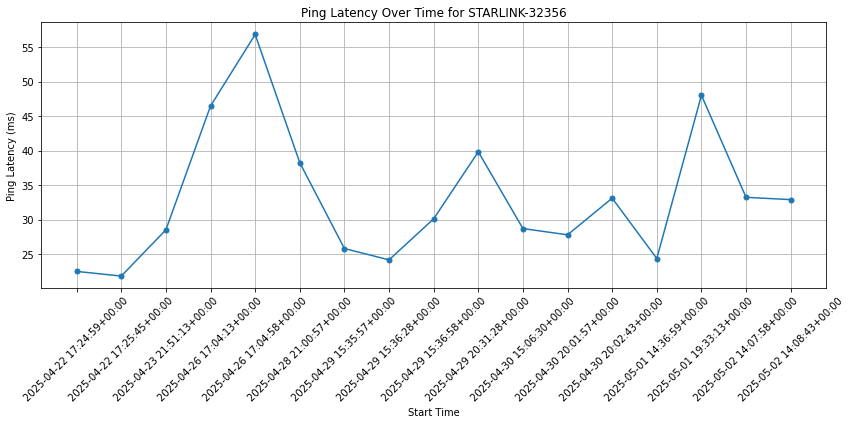

In [45]:
new_df = df_conn_periods[df_conn_periods['Satellite'] == 'STARLINK-32356']
print(f"Number of rows for STARLINK-5185: {len(new_df)}")
print(new_df['Mean_Altitude_km'])

print(new_df['Start_Time'].nunique())
print(new_df[['Start_Time', 'End_Time']])

plt.figure(figsize=(12, 6))
plt.plot(new_df['Start_Time'], new_df['Mean_popPingLatencyMs'], marker='o', linestyle='-', markersize=5)
plt.xlabel('Start Time')
plt.xticks(rotation=45)
plt.ylabel('Ping Latency (ms)')
plt.title('Ping Latency Over Time for STARLINK-32356')
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
def extract_mean_motion(tle_line2):
    try:
        # Extract characters at positions 53-63 (0-indexed: 52–63, exclusive)
        mean_motion_str = tle_line2[52:63].strip()
        return float(mean_motion_str)
    except Exception:
        return None

# Compute mean motion and orbital periods
df_conn_periods['Mean_Motion'] = df_conn_periods['TLE_Line2'].apply(extract_mean_motion)
df_conn_periods['Orbital_Period_Minutes'] = df_conn_periods['Mean_Motion'].apply(
    lambda n: 1440 / n if pd.notnull(n) and n != 0 else None
)
df_conn_periods['Orbital_Period_Days'] = df_conn_periods['Mean_Motion'].apply(
    lambda n: 1 / n if pd.notnull(n) and n != 0 else None
)

# Preview
print(df_conn_periods[['Satellite', 'Mean_Motion', 'Orbital_Period_Minutes', 'Mean_Altitude_km']].head())


        Satellite  Mean_Motion  Orbital_Period_Minutes  Mean_Altitude_km
0   STARLINK-1972    15.064113               95.591421        552.169724
1   STARLINK-5185    15.088069               95.439647        544.368547
2   STARLINK-5507    14.983364               96.106589        579.926336
3   STARLINK-3629    15.088412               95.437478        544.491614
4  STARLINK-30272    15.302081               94.104850        480.316056


In [59]:
import datetime
from skyfield.api import load
def get_visible_satellites(timestamp_str, all_satellites, centralLat, centralLon, offsetLat, offsetLon):
    timestamp_dt = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S%z")
    timescale = load.timescale(builtin=True)
    time_ts = timescale.utc(
        timestamp_dt.year,
        timestamp_dt.month,
        timestamp_dt.day,
        timestamp_dt.hour,
        timestamp_dt.minute,
        timestamp_dt.second,
    )

    visible_sats = []

    for sat in all_satellites:
        geocentric = sat.at(time_ts)
        subsat = geocentric.subpoint()
        lat = subsat.latitude.degrees
        lon = subsat.longitude.degrees

        if (
            centralLat - offsetLat * 1.5 < lat < centralLat + offsetLat * 1.5
            and centralLon - offsetLon < lon < centralLon + offsetLon
        ):
            visible_sats.append(sat.name)

    return visible_sats


In [ ]:
from tqdm import tqdm

# Only if tqdm isn't already installed
# !pip install tqdm

visible_satellite_lists = []

# Use tqdm for progress bar during iteration
for _, row in tqdm(df_conn_periods.iterrows(), total=len(df_conn_periods)):
    timestamp_str = row['Start_Time']
    visible_sats = get_visible_satellites(
        timestamp_str,
        all_satellites,
        centralLat=44.97,   # Replace with your actual value
        centralLon=-93.26,  # Replace with your actual value
        offsetLat=5,        # Adjust as needed
        offsetLon=10        # Adjust as needed
    )
    visible_satellite_lists.append(visible_sats)

df_conn_periods['Visible_Satellites'] = visible_satellite_lists
